## References:
- [Flower Classification](https://www.kaggle.com/datasets/marquis03/flower-classification)
- [Convolutional Neural Networks](https://ithelp.ithome.com.tw/articles/10262751)

## Import Libraries

In [ ]:
#from tflite_model_maker import model_spec
#from tflite_model_maker import image_classifier
#from tflite_model_maker.config import ExportFormat
#from tflite_model_maker.config import QuantizationConfig
#from tflite_model_maker.image_classifier import DataLoader

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#assert tf.__version__.startswith('2')

# plot_model
# pip install pydot
# pip install pydotplus
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

# pip install scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import os, warnings, cv2  # pip install opencv-python
warnings.filterwarnings('ignore')

## Read Dataset

In [2]:
train_path = os.path.join('input', 'train')
validation_path = os.path.join('input', 'val')
pd.DataFrame(zip(os.listdir(train_path), os.listdir(validation_path)), columns=['Species_Train', 'Species_Val'])

,Species_Train,Species_Val
0,astilbe,astilbe
1,bellflower,bellflower
2,black_eyed_susan,black_eyed_susan
3,calendula,calendula
4,california_poppy,california_poppy
5,carnation,carnation
6,common_daisy,common_daisy
7,coreopsis,coreopsis
8,dandelion,dandelion
9,iris,iris


In [3]:
#train, validation = [], []
#for dirname, _, filenames in os.walk(train_path):
#    flower_type = []
#    for filename in filenames:
#        flower_type.append(os.path.join(dirname, filename))
#    i = int(len(flower_type) * 0.8)
#    train += flower_type[:i]
#    validation += flower_type[i:]

#np.random.shuffle(train)
#np.random.shuffle(validation)

#train_label = [os.path.basename(os.path.dirname(path)) for path in train]
#validation_label = [os.path.basename(os.path.dirname(path)) for path in validation]

#train_df = pd.DataFrame(zip(train, train_label), columns=['Image', 'Label'])
#validation_df = pd.DataFrame(zip(validation, validation_label), columns=['Image', 'Label'])

In [4]:
files = []
for dirname, _, filenames in os.walk(train_path):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
np.random.shuffle(files)

label = [os.path.basename(os.path.dirname(path)) for path in files]
df = pd.DataFrame(zip(files, label), columns=['Image', 'Label'])

## Visualization

<Axes: xlabel='Label', ylabel='count'>

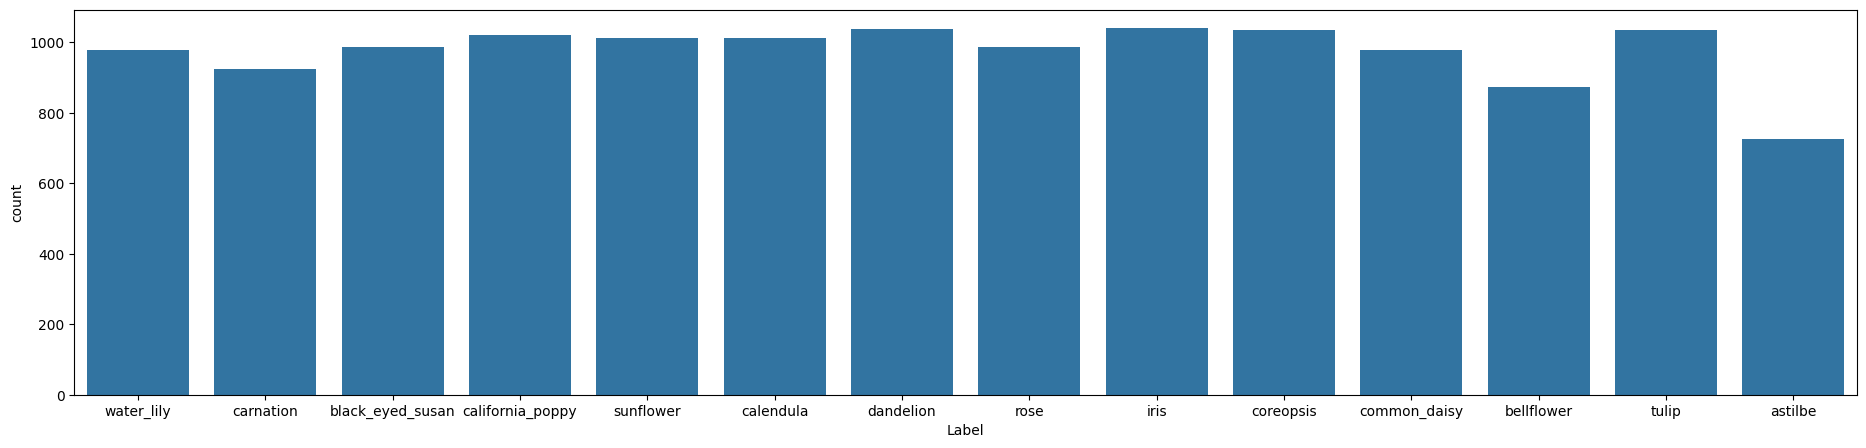

In [5]:
plt.figure(figsize=(23, 5))
sns.countplot(x=df['Label'])#.set_title('Train')

## Split Dataset

In [6]:
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset='training',
    seed=666,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset='validation',
    seed=666,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 13642 files belonging to 14 classes.
Using 10914 files for training.
Found 13642 files belonging to 14 classes.
Using 2728 files for validation.


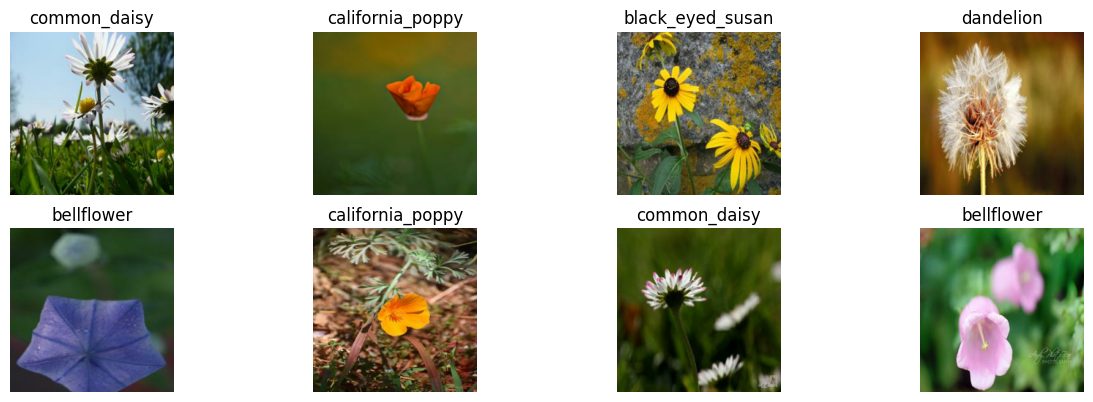

In [7]:
plt.figure(figsize=(15, 20))
for images, labels in train_data.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_data.class_names[labels[i]])
        plt.axis('off')

## Modeling

### MobileNetV3Large

In [8]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False
keras_model = keras.models.Sequential([
    base_model,
    # Fix overfitting
    keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal', input_shape=(7, 7, 960)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1)
    ]),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),  # Fix overfitting
    keras.layers.Dense(14, activation=tf.nn.softmax)
])
keras_model.build((None, img_height, img_width, 3))
keras_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 7, 7, 960)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 47040)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47040)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │         658,574 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,654,926 (13.94 MB)

 Trainable params: 658,574 (2.51 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [9]:
#tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True, show_dtype=True, dpi=80)

In [10]:
checkpoint = ModelCheckpoint('my_keras_model.keras', save_best_only=True)

In [11]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [12]:
keras_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_fit = keras_model.fit(train_data, epochs=20, validation_data=validation_data, callbacks=[checkpoint, early_stopping])

Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 67s 182ms/step - accuracy: 0.7460 - loss: 2.3729 - val_accuracy: 0.8713 - val_loss: 1.9285
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.9144 - loss: 1.1417 - val_accuracy: 0.8882 - val_loss: 2.1670
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 63s 183ms/step - accuracy: 0.9312 - loss: 0.9221 - val_accuracy: 0.8820 - val_loss: 2.6728
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 63s 185ms/step - accuracy: 0.9547 - loss: 0.6149 - val_accuracy: 0.8955 - val_loss: 2.4530
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - accuracy: 0.9549 - loss: 0.5850 - val_accuracy: 0.9007 - val_loss: 2.6920
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 177ms/step - accuracy: 0.9608 - loss: 0.5097 - val_accuracy: 0.9076 - val_loss: 2.9458


In [13]:
hist = pd.DataFrame(model_fit.history)
hist

,accuracy,loss,val_accuracy,val_loss
0,0.823713,1.940188,0.871334,1.928475
1,0.914147,1.118272,0.888196,2.167020
2,0.936320,0.849315,0.881965,2.672758
3,0.953454,0.641089,0.895528,2.452997
4,0.958860,0.538624,0.900660,2.691958
5,0.963167,0.495718,0.907625,2.945768


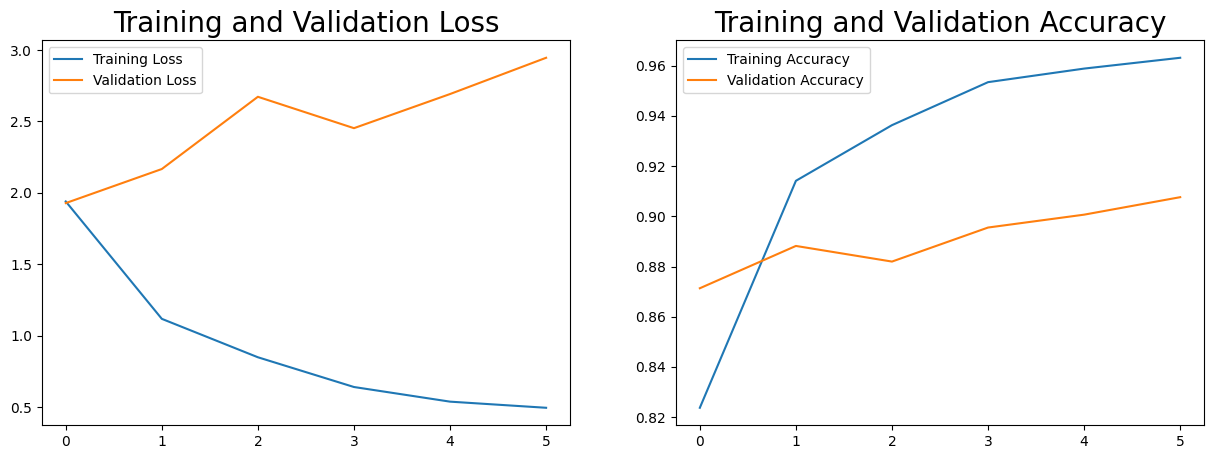

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=20)
plt.legend()

In [15]:
score, acc = keras_model.evaluate(validation_data)
print('Validation Loss =', score)
print('Validation Accuracy =', acc)

86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.8735 - loss: 1.8045
Validation Loss = 1.9284756183624268
Validation Accuracy = 0.8713343143463135


#### Predict Test Data

In [16]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    validation_path,
    image_size=(img_height, img_width),
    validation_split=None,
)

Found 98 files belonging to 14 classes.


In [17]:
test_score, test_acc = keras_model.evaluate(test_data)
print('Test Loss =', test_score)
print('Test Accuracy =', test_acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9102 - loss: 1.6371 
Test Loss = 1.8254687786102295
Test Accuracy = 0.8979591727256775


#### Loss & Accuracy

In [18]:
accuracy = [('Validation', score, acc), ('Test', test_score, test_acc)]
predict_test = pd.DataFrame(data=accuracy, columns=['Model', 'Loss', 'Accuracy'])
predict_test

,Model,Loss,Accuracy
0,Validation,1.928476,0.871334
1,Test,1.825469,0.897959


### Convolutional Neural Networks

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
num_classes = 14

keras_model = keras.models.Sequential([
    # Fix overfitting
    keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1)
    ]),
    
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),  # Fix overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

keras_model.build((None, img_height, img_width, 3))
keras_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,448,046 (24.60 MB)

 Trainable params: 6,448,046 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
keras_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_fit = keras_model.fit(train_data, validation_data=validation_data, epochs=20)

Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 47s 126ms/step - accuracy: 0.3001 - loss: 2.0406 - val_accuracy: 0.5018 - val_loss: 1.4696
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 49s 144ms/step - accuracy: 0.5185 - loss: 1.3915 - val_accuracy: 0.5422 - val_loss: 1.3760
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 48s 140ms/step - accuracy: 0.5831 - loss: 1.2015 - val_accuracy: 0.6569 - val_loss: 1.0358
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 48s 140ms/step - accuracy: 0.6485 - loss: 1.0347 - val_accuracy: 0.6419 - val_loss: 1.0737
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 49s 144ms/step - accuracy: 0.6681 - loss: 0.9654 - val_accuracy: 0.6913 - val_loss: 0.9336
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 50s 147ms/step - accuracy: 0.6974 - loss: 0.8795 - val_accuracy: 0.6716 - val_loss: 0.9730
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 47s 138ms/step - accuracy: 0.7076 - loss: 0.8482 - val_accuracy: 0.7093 - val_loss: 0.9020
Epoch 8/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 48s 139ms/step - accuracy: 0.7426 - loss: 0

In [22]:
hist = pd.DataFrame(model_fit.history)
hist

,accuracy,loss,val_accuracy,val_loss
0,0.388950,1.762234,0.501833,1.469633
1,0.533077,1.342973,0.542155,1.375966
2,0.593641,1.166509,0.656892,1.035794
3,0.643485,1.042969,0.641862,1.073658
4,0.673813,0.954510,0.691349,0.933561
5,0.692139,0.887060,0.671554,0.972956
6,0.714404,0.820486,0.709311,0.901953
7,0.734103,0.772387,0.708578,0.896755
8,0.750412,0.716099,0.714809,0.906123
9,0.766722,0.682374,0.723240,0.899034


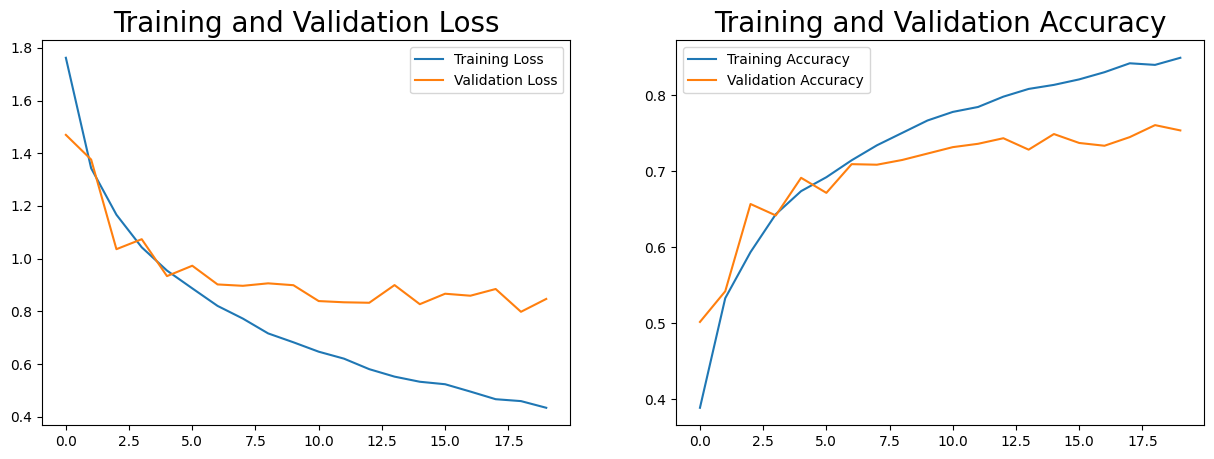

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=20)
plt.legend()

In [24]:
score, acc = keras_model.evaluate(validation_data)
print('Validation Loss =', score)
print('Validation Accuracy =', acc)

86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7482 - loss: 0.8929
Validation Loss = 0.8469334840774536
Validation Accuracy = 0.7536656856536865


#### Predict Test Data

In [25]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    validation_path,
    image_size=(img_height, img_width),
    validation_split=None,
)

Found 98 files belonging to 14 classes.


In [26]:
test_score, test_acc = keras_model.evaluate(test_data)
print('Test Loss =', test_score)
print('Test Accuracy =', test_acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7460 - loss: 0.8423
Test Loss = 0.8001416921615601
Test Accuracy = 0.7346938848495483


#### Loss & Accuracy

In [27]:
accuracy = [('Validation', score, acc), ('Test', test_score, test_acc)]
predict_test = pd.DataFrame(data=accuracy, columns=['Model', 'Loss', 'Accuracy'])
predict_test

,Model,Loss,Accuracy
0,Validation,0.846933,0.753666
1,Test,0.800142,0.734694
